## 데이터 전처리

### 수치형
사상자수, 사망자수, 중상자수, 경상자수, 부상신고자수

### 범주형
주야, 요일, 발생지시도, 발생지시군구, 
사고유형_대분류, 사고유형_중분류, 법규위반, 도로형태_대분류,
도로형태, 당사자종별_1당_대분류, 당사자종별_2당_대분류

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, LabelBinarizer, OneHotEncoder, MultiLabelBinarizer

In [2]:
categorical = ['주야', '요일', '발생지시도', '발생지시군구', '사고유형_대분류', '사고유형_중분류', '법규위반', 
            '도로형태_대분류', '도로형태', '당사자종별_1당_대분류', '당사자종별_2당_대분류']
numerical = ['사상자수', '사망자수', '중상자수', '경상자수','부상신고자수']
x_train_num = pd.read_csv('./교통사망사고정보/Kor_Train_교통사망사고정보(12.1~17.6).csv',encoding='cp949', 
                              usecols=numerical)

x_train_cat = pd.read_csv('./교통사망사고정보/Kor_Train_교통사망사고정보(12.1~17.6).csv',encoding='cp949',
                               usecols=categorical)


In [3]:
x_test_num = pd.read_csv('./test_kor.csv',encoding='cp949', 
                              usecols=numerical)

x_test_cat = pd.read_csv('./test_kor.csv',encoding='cp949',
                               usecols=categorical)

### One Hot Encdoing을 나열해서 만드는 방법

In [4]:
all_data = pd.concat((x_test_cat.dropna(),x_train_cat))
# for col in all_data.select_dtypes(include=[np.object]).columns:
#     print(col, all_data[col].unique())

In [5]:
for column in all_data.select_dtypes(include=[np.object]).columns:
    x_train_cat[column] = x_train_cat[column].astype('category', categories = all_data[column].unique())
    x_test_cat[column] = x_test_cat[column].astype('category', categories = all_data[column].unique())

/home/iron/.local/lib/python3.5/site-packages/ipykernel_launcher.py:2: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  
/home/iron/.local/lib/python3.5/site-packages/ipykernel_launcher.py:3: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  This is separate from the ipykernel package so we can avoid doing imports until


In [6]:
x_train_cat = pd.get_dummies(data=x_train_cat)
x_test_cat = pd.get_dummies(data=x_test_cat)

In [7]:
print(x_train_cat.shape)
print(x_test_cat.shape)

(25037, 328)
(50, 328)


# Deep Learning

In [8]:
import keras
from keras.layers import Dense, Input, LSTM, concatenate, Dropout, Conv2D, MaxPool2D, Embedding, Reshape, Conv1D
from keras.models import Sequential, Model
from keras.utils import np_utils
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras import metrics
from keras import backend as K

Using TensorFlow backend.


In [9]:
print(x_train_cat.shape)
print(x_train_num.shape)
print(x_test_cat.shape)
print(x_test_num.shape)

(25037, 328)
(25037, 5)
(50, 328)
(50, 5)


In [10]:
Case1 = ['사망자수','사상자수','경상자수']
Case2 = ['사상자수', '중상자수', '부상신고자수']
Case3 = ['사상자수', '중상자수', '경상자수' ]
Case4 = ['사망자수', '사상자수', '중상자수' ]

수치형 데이터 Case 함수

In [11]:
def numerical_case(case, start, end):
    
    K.clear_session()
    
    print("Case:", case)
    X = x_train_num.drop(columns=case)
    X_test = x_test_num.drop(columns=case)
    
    case_copy=case.copy()
    if '사상자수' in case:       
        case_copy.remove('사상자수')
    print('사상자제거:', case_copy)
    Y = x_train_num[case_copy].values
    
    # 수치형 데이터와 범주형 데이터 합치기
    X = pd.concat([X, x_train_cat], axis=1).values
    X_test = pd.concat([X_test, x_test_cat],axis=1).values
    
    print(X)
    print(Y)
    
    # 모델 정의
    num_input = Input(shape=(len(X[0]),), name='num_input')
    x = Dense(512, activation='relu')(num_input)
    x = Dropout(0.3)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    num_output = Dense(len(Y[0]), name='num_output')(x)

    model = Model(inputs=num_input, outputs=num_output)

    model.compile(optimizer='sgd',
                  loss='mse',
                  metrics=['accuracy'])



    
    
    learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                        patience=25, 
                                        verbose=1, 
                                        factor=0.5, 
                                        min_lr=0.00000001)

    callbacks = [
    #         learning_rate_reduction, # learning_rate를 점차 감소시킴으로서 최적값에 접근하는 방식
        EarlyStopping('val_loss', patience=5)# val_loss이 최적값에서 멀어지는 순간 epoch가 남아도 학습 중지
    ]
    
    history = model.fit(X, Y, epochs=50, batch_size=128, callbacks=callbacks,validation_split=0.2 )
    
    
    # make a prediction
    Y_test = model.predict(X_test[range(start, end+1)])
    
    # show the inputs and predicted outputs
    print("X=%s, Predicted=%s" % (X_test[range(start, end+1)],  Y_test ))
    del model
    
    return Y_test

In [107]:
Case1_pre = numerical_case(Case1, 0,1)

Case: ['사망자수', '사상자수', '경상자수']
[[0 0 1 ... 0 0 0]
 [2 0 1 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 1 ... 0 0 0]
 [5 0 1 ... 0 0 0]
 [0 0 1 ... 0 0 0]]
[[1 0]
 [1 1]
 [1 0]
 ...
 [1 0]
 [1 0]
 [1 0]]
Train on 20029 samples, validate on 5008 samples
Epoch 1/50
20029/20029 [==============================] - 1s 67us/step - loss: 0.7096 - acc: 0.9364 - val_loss: 0.6200 - val_acc: 0.9555
Epoch 2/50
20029/20029 [==============================] - 1s 32us/step - loss: 0.6186 - acc: 0.9540 - val_loss: 0.5800 - val_acc: 0.9413
Epoch 3/50
20029/20029 [==============================] - 1s 31us/step - loss: 0.6067 - acc: 0.9463 - val_loss: 0.6301 - val_acc: 0.9499
Epoch 4/50
20029/20029 [==============================] - 1s 31us/step - loss: 0.5999 - acc: 0.9475 - val_loss: 0.5553 - val_acc: 0.9303
Epoch 5/50
20029/20029 [==============================] - 1s 31us/step - loss: 0.5969 - acc: 0.9441 - val_loss: 0.5633 - val_acc: 0.9399
Epoch 6/50
20029/20029 [==============================] - 1s 32us/s

In [117]:
numerical_case(Case2, 2,3)

Case: ['사상자수', '중상자수', '부상신고자수']
사상자제거: ['중상자수', '부상신고자수']
[[1 0 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 0 1 ... 0 0 0]
 ...
 [1 0 1 ... 0 0 0]
 [1 0 1 ... 0 0 0]
 [1 0 1 ... 0 0 0]]
[[0 0]
 [2 0]
 [0 0]
 ...
 [0 0]
 [5 0]
 [0 0]]
Train on 20029 samples, validate on 5008 samples
Epoch 1/50
20029/20029 [==============================] - 1s 38us/step - loss: 0.5868 - acc: 0.9350 - val_loss: 0.9553 - val_acc: 0.9892
Epoch 2/50
20029/20029 [==============================] - 1s 29us/step - loss: 0.5523 - acc: 0.9065 - val_loss: 0.9362 - val_acc: 0.9048
Epoch 3/50
20029/20029 [==============================] - 1s 29us/step - loss: 0.5314 - acc: 0.8812 - val_loss: 0.9234 - val_acc: 0.8516
Epoch 4/50
20029/20029 [==============================] - 1s 30us/step - loss: 0.5370 - acc: 0.8613 - val_loss: 0.9144 - val_acc: 0.8307
Epoch 5/50
20029/20029 [==============================] - 1s 29us/step - loss: 0.5319 - acc: 0.8345 - val_loss: 0.9187 - val_acc: 0.7346
Epoch 6/50
20029/20029 [===============

In [112]:
numerical_case(Case3, 4,6)

Case: ['사상자수', '중상자수', '경상자수']
사상자제거: ['중상자수', '경상자수']
[[1 0 1 ... 0 0 0]
 [1 0 1 ... 0 0 0]
 [1 0 1 ... 0 0 0]
 ...
 [1 0 1 ... 0 0 0]
 [1 0 1 ... 0 0 0]
 [1 0 1 ... 0 0 0]]
[[0 0]
 [2 1]
 [0 0]
 ...
 [0 0]
 [5 0]
 [0 0]]
Train on 20029 samples, validate on 5008 samples
Epoch 1/50
20029/20029 [==============================] - 1s 72us/step - loss: 1.1981 - acc: 0.5969 - val_loss: 1.1850 - val_acc: 0.8205
Epoch 2/50
20029/20029 [==============================] - 1s 32us/step - loss: 1.1693 - acc: 0.6264 - val_loss: 1.1498 - val_acc: 0.8161
Epoch 3/50
20029/20029 [==============================] - 1s 31us/step - loss: 1.1427 - acc: 0.6227 - val_loss: 1.1051 - val_acc: 0.8161
Epoch 4/50
20029/20029 [==============================] - 1s 31us/step - loss: 1.1166 - acc: 0.6242 - val_loss: 1.0792 - val_acc: 0.7802
Epoch 5/50
20029/20029 [==============================] - 1s 31us/step - loss: 1.1065 - acc: 0.6075 - val_loss: 1.0780 - val_acc: 0.8397
Epoch 6/50
20029/20029 [===================

In [175]:
numerical_case(Case4, 7, 9)

Case: ['사망자수', '사상자수', '중상자수']
사상자제거: ['사망자수', '중상자수']
[[0 0 1 ... 0 0 0]
 [1 0 1 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 1 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [0 0 1 ... 0 0 0]]
[[1 0]
 [1 2]
 [1 0]
 ...
 [1 0]
 [1 5]
 [1 0]]
Train on 20029 samples, validate on 5008 samples
Epoch 1/50
20029/20029 [==============================] - 1s 32us/step - loss: 0.6125 - acc: 0.9332 - val_loss: 0.5379 - val_acc: 0.9397
Epoch 2/50
20029/20029 [==============================] - 1s 27us/step - loss: 0.5393 - acc: 0.9438 - val_loss: 0.5133 - val_acc: 0.9335
Epoch 3/50
20029/20029 [==============================] - 1s 26us/step - loss: 0.5302 - acc: 0.9377 - val_loss: 0.5148 - val_acc: 0.9325
Epoch 4/50
20029/20029 [==============================] - 1s 27us/step - loss: 0.5245 - acc: 0.9383 - val_loss: 0.5146 - val_acc: 0.9329
Epoch 5/50
20029/20029 [==============================] - 1s 27us/step - loss: 0.5203 - acc: 0.9375 - val_loss: 0.5130 - val_acc: 0.9327
Epoch 6/50
20029/20029 [===================

### Case 4
'사망자수', '사상자수', '중상자수' 예측

In [177]:
Y = x_train_num[['사망자수', '중상자수']].values
X = x_train_num.drop(columns=['사망자수', '사상자수', '중상자수'])

In [178]:
X = pd.concat([X, x_train_cat], axis=1).values

Test Data 생성

In [179]:
X_test = x_test_num.drop(columns=['사망자수', '사상자수', '중상자수'])
X_test = pd.concat([X_test, x_test_cat],axis=1).values

In [180]:
print(X.shape)
print(Y.shape)

(25037, 330)
(25037, 2)


In [181]:
num_input = Input(shape=(len(X[0]),), name='num_input')
x = Dense(512, activation='relu')(num_input)
x = Dropout(0.3)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
num_output = Dense(len(Y[0]), name='num_output')(x)

In [182]:
model = Model(inputs=num_input, outputs=num_output)

In [183]:
model.compile(optimizer='adam',
              loss='mse',
              metrics=['accuracy'])

In [184]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=25, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00000001)

callbacks = [
    learning_rate_reduction, # learning_rate를 점차 감소시킴으로서 최적값에 접근하는 방식
                                        # approach to get optimal value by gradually decreasing learning_rate
    EarlyStopping('val_loss', patience=5), # val_loss이 최적값에서 멀어지는 순간 epoch가 남아도 학습 중지
                                                            # If val_loss deviates from the optimal value, 
                                                            # learning stops even if epoch remains.
    ModelCheckpoint('model.h5', save_best_only=True)] # 모델을 학습시키면서 지금까지 등장했던 최적의 weight들을 항상 저장한다.

In [185]:
history = model.fit(X, Y, epochs=50, batch_size=128, callbacks=callbacks,validation_split=0.2 )

Train on 20029 samples, validate on 5008 samples
Epoch 1/50
20029/20029 [==============================] - 1s 45us/step - loss: 0.5790 - acc: 0.9280 - val_loss: 0.5130 - val_acc: 0.9065
Epoch 2/50
20029/20029 [==============================] - 1s 37us/step - loss: 0.4934 - acc: 0.9273 - val_loss: 0.5085 - val_acc: 0.9187
Epoch 3/50
20029/20029 [==============================] - 1s 35us/step - loss: 0.4872 - acc: 0.9289 - val_loss: 0.5204 - val_acc: 0.9283
Epoch 4/50
20029/20029 [==============================] - 1s 36us/step - loss: 0.5168 - acc: 0.9328 - val_loss: 0.4991 - val_acc: 0.9151
Epoch 5/50
20029/20029 [==============================] - 1s 35us/step - loss: 0.4498 - acc: 0.9331 - val_loss: 0.4840 - val_acc: 0.9303
Epoch 6/50
20029/20029 [==============================] - 1s 38us/step - loss: 0.3782 - acc: 0.9378 - val_loss: 0.5003 - val_acc: 0.9189
Epoch 7/50
20029/20029 [==============================] - 1s 39us/step - loss: 0.3553 - acc: 0.9418 - val_loss: 0.4645 - val_acc:

In [186]:
# make a prediction
Y_test = model.predict(X_test[7:10])

# show the inputs and predicted outputs
print("X=%s, Predicted=%s" % (X_test[7:10],  Y_test ))

X=[[ 5.  0.  0.  1.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  1.  0.  0.  0.  0.  0.  0

In [369]:
Case5 = ['사고유형_대분류', '사고유형_중분류', '법규위반']
Case6 = ['도로형태_대분류', '도로형태', '당사자종별_1당_대분류']
Case7 = ['도로형태_대분류', '도로형태', '당사자종별_2당_대분류']
Case8 = ['도로형태_대분류', '도로형태', '당사자종별_1당_대분류', '당사자종별_2당_대분류']
Case11 = ['발생지시도', '발생지시군구']
Case12 = ['요일', '사고유형_대분류', '사고유형_중분류']
Case13 = ['요일', '사고유형_중분류', '법규위반', '도로형태_대분류']

In [379]:
def categorical_case(case, start, end):
    col_name = [] # ex. '사고유형_대분류_차대차', '사고유형_대분류_차대사람', '사고유형_대분류_차량단독'
    label_name = [] #  ex. '차대차', '차대사람', '차량단독
    
    for col in case:
        label_name.extend(all_data[col].unique()) 
        for name in all_data[col].unique():
            col_name.append(col+'_'+name)
    
    print('col_name:',col_name)
    print('label_name:', label_name)
                
    Y = x_train_cat[col_name].values
    X = x_train_cat.drop(columns=col_name)
    X = pd.concat([X, x_train_num], axis=1).values

    X_test = x_test_cat.drop(columns=col_name)
    X_test = pd.concat([X_test, x_test_num],axis=1).values

    print(X.shape)
    print(Y.shape)

    cat_input = Input(shape=(len(X[0]),), name='cat_input')
    x = Dense(512, activation='relu')(cat_input)
    x = Dropout(0.3)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    cat_output = Dense(len(Y[0]), activation='sigmoid', name='cat_output')(x)

    model = Model(inputs=cat_input, outputs=cat_output)

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                                patience=25, 
                                                verbose=1, 
                                                factor=0.5, 
                                                min_lr=0.00000001)

    callbacks = [
        learning_rate_reduction, # learning_rate를 점차 감소시킴으로서 최적값에 접근하는 방식
        EarlyStopping('val_loss', patience=10), # val_loss이 최적값에서 멀어지는 순간 epoch가 남아도 학습 중지
        ]

    history = model.fit(X, Y, epochs=50, batch_size=128, callbacks=callbacks,validation_split=0.2 )
    
    
    # make a prediction
    Y_test = model.predict(X_test[range(start, end+1)])
    
    # show the inputs and predicted outputs
#     print("X=%s, Predicted=%s" % (X_test[range(start, end+1)],  Y_test ))
    
            
        
    '''
    예시 출력:
        사고유형_대분류 : 차량단독
        사고유형_중분류 : 공작물충돌
        법규위반 : 안전운전 의무 불이행
    '''
    for val in Y_test: 
        x_list = list(val)
        label_name_x = label_name.copy()
        for col in case:
            print(col, ':',label_name_x[x_list.index(max(x_list[0:len(all_data[col].unique())]))] )
            del x_list[:len(all_data[col].unique())]
            del label_name_x[:len(all_data[col].unique())]
        print()


In [341]:
categorical_case(Case5, 10,19)

col_name: ['사고유형_대분류_차대차', '사고유형_대분류_차대사람', '사고유형_대분류_차량단독', '사고유형_대분류_건널목', '사고유형_중분류_측면충돌', '사고유형_중분류_차도통행중', '사고유형_중분류_전도전복', '사고유형_중분류_정면충돌', '사고유형_중분류_추돌', '사고유형_중분류_횡단중', '사고유형_중분류_기타', '사고유형_중분류_전도', '사고유형_중분류_도로이탈', '사고유형_중분류_길가장자리구역통행중', '사고유형_중분류_공작물충돌', '사고유형_중분류_전복', '사고유형_중분류_보도통행중', '사고유형_중분류_후진중충돌', '사고유형_중분류_주/정차차량 충돌', '사고유형_중분류_측면직각충돌', '사고유형_중분류_차단기돌파', '사고유형_중분류_직전진행', '사고유형_중분류_경보기무시', '법규위반_중앙선 침범', '법규위반_과속', '법규위반_안전운전 의무 불이행', '법규위반_안전거리 미확보', '법규위반_기타(운전자법규위반)', '법규위반_신호위반', '법규위반_직진 및 우회전차의 통행방해', '법규위반_교차로 통행방법 위반', '법규위반_보행자 보호의무 위반', '법규위반_부당한 회전', '법규위반_차로위반(진로변경 위반)', '법규위반_앞지르기 금지위반', '법규위반_앞지르기 방법위반', '법규위반_정비불량 제차의 운전금지위반', '법규위반_서행 및 일시정지위반', '법규위반_과로', '법규위반_철길건널목 통과방법위반', '법규위반_진로양보 의무 불이행', '법규위반_보행자과실', '법규위반_통행우선 순위위반']
label_name: ['차대차', '차대사람', '차량단독', '건널목', '측면충돌', '차도통행중', '전도전복', '정면충돌', '추돌', '횡단중', '기타', '전도', '도로이탈', '길가장자리구역통행중', '공작물충돌', '전복', '보도통행중', '후진중충돌', '주/정차차량 충돌', '측면직각충돌', '차단기돌파', '직전진행', '경보기무시', '중앙선 침범', '과속', '안전운전 의무

In [339]:
categorical_case(Case6, 20, 22)

col_name: ['도로형태_대분류_단일로', '도로형태_대분류_교차로', '도로형태_대분류_기타', '도로형태_대분류_주차장', '도로형태_대분류_불명', '도로형태_대분류_기타/불명', '도로형태_대분류_고가도로위', '도로형태_대분류_지하도로내', '도로형태_대분류_건널목', '도로형태_기타단일로', '도로형태_교차로내', '도로형태_교차로부근', '도로형태_교량위', '도로형태_고가도로위', '도로형태_교차로횡단보도내', '도로형태_기타', '도로형태_지하차도(도로)내', '도로형태_주차장', '도로형태_터널안', '도로형태_불명', '도로형태_횡단보도상', '도로형태_횡단보도부근', '도로형태_기타/불명', '도로형태_지하도로내', '도로형태_건널목', '당사자종별_1당_대분류_승용차', '당사자종별_1당_대분류_자전거', '당사자종별_1당_대분류_화물차', '당사자종별_1당_대분류_승합차', '당사자종별_1당_대분류_건설기계', '당사자종별_1당_대분류_이륜차', '당사자종별_1당_대분류_특수차', '당사자종별_1당_대분류_원동기장치자전거', '당사자종별_1당_대분류_사륜오토바이(ATV)', '당사자종별_1당_대분류_농기계', '당사자종별_1당_대분류_개인형이동수단(PM)', '당사자종별_1당_대분류_불명']
label_name: ['단일로', '교차로', '기타', '주차장', '불명', '기타/불명', '고가도로위', '지하도로내', '건널목', '기타단일로', '교차로내', '교차로부근', '교량위', '고가도로위', '교차로횡단보도내', '기타', '지하차도(도로)내', '주차장', '터널안', '불명', '횡단보도상', '횡단보도부근', '기타/불명', '지하도로내', '건널목', '승용차', '자전거', '화물차', '승합차', '건설기계', '이륜차', '특수차', '원동기장치자전거', '사륜오토바이(ATV)', '농기계', '개인형이동수단(PM)', '불명']
(25037, 296)
(25037, 37)
Train on 20029 s

In [342]:
categorical_case(Case7, 23, 25)

col_name: ['도로형태_대분류_단일로', '도로형태_대분류_교차로', '도로형태_대분류_기타', '도로형태_대분류_주차장', '도로형태_대분류_불명', '도로형태_대분류_기타/불명', '도로형태_대분류_고가도로위', '도로형태_대분류_지하도로내', '도로형태_대분류_건널목', '도로형태_기타단일로', '도로형태_교차로내', '도로형태_교차로부근', '도로형태_교량위', '도로형태_고가도로위', '도로형태_교차로횡단보도내', '도로형태_기타', '도로형태_지하차도(도로)내', '도로형태_주차장', '도로형태_터널안', '도로형태_불명', '도로형태_횡단보도상', '도로형태_횡단보도부근', '도로형태_기타/불명', '도로형태_지하도로내', '도로형태_건널목', '당사자종별_2당_대분류_승합차', '당사자종별_2당_대분류_보행자', '당사자종별_2당_대분류_없음', '당사자종별_2당_대분류_화물차', '당사자종별_2당_대분류_특수차', '당사자종별_2당_대분류_승용차', '당사자종별_2당_대분류_이륜차', '당사자종별_2당_대분류_농기계', '당사자종별_2당_대분류_원동기장치자전거', '당사자종별_2당_대분류_자전거', '당사자종별_2당_대분류_사륜오토바이(ATV)', '당사자종별_2당_대분류_건설기계', '당사자종별_2당_대분류_불명', '당사자종별_2당_대분류_열차']
label_name: ['단일로', '교차로', '기타', '주차장', '불명', '기타/불명', '고가도로위', '지하도로내', '건널목', '기타단일로', '교차로내', '교차로부근', '교량위', '고가도로위', '교차로횡단보도내', '기타', '지하차도(도로)내', '주차장', '터널안', '불명', '횡단보도상', '횡단보도부근', '기타/불명', '지하도로내', '건널목', '승합차', '보행자', '없음', '화물차', '특수차', '승용차', '이륜차', '농기계', '원동기장치자전거', '자전거', '사륜오토바이(ATV)', '건설기계', '불명', '열차']
(25037,

In [344]:
categorical_case(Case8, 26, 29)

col_name: ['도로형태_대분류_단일로', '도로형태_대분류_교차로', '도로형태_대분류_기타', '도로형태_대분류_주차장', '도로형태_대분류_불명', '도로형태_대분류_기타/불명', '도로형태_대분류_고가도로위', '도로형태_대분류_지하도로내', '도로형태_대분류_건널목', '도로형태_기타단일로', '도로형태_교차로내', '도로형태_교차로부근', '도로형태_교량위', '도로형태_고가도로위', '도로형태_교차로횡단보도내', '도로형태_기타', '도로형태_지하차도(도로)내', '도로형태_주차장', '도로형태_터널안', '도로형태_불명', '도로형태_횡단보도상', '도로형태_횡단보도부근', '도로형태_기타/불명', '도로형태_지하도로내', '도로형태_건널목', '당사자종별_1당_대분류_승용차', '당사자종별_1당_대분류_자전거', '당사자종별_1당_대분류_화물차', '당사자종별_1당_대분류_승합차', '당사자종별_1당_대분류_건설기계', '당사자종별_1당_대분류_이륜차', '당사자종별_1당_대분류_특수차', '당사자종별_1당_대분류_원동기장치자전거', '당사자종별_1당_대분류_사륜오토바이(ATV)', '당사자종별_1당_대분류_농기계', '당사자종별_1당_대분류_개인형이동수단(PM)', '당사자종별_1당_대분류_불명', '당사자종별_2당_대분류_승합차', '당사자종별_2당_대분류_보행자', '당사자종별_2당_대분류_없음', '당사자종별_2당_대분류_화물차', '당사자종별_2당_대분류_특수차', '당사자종별_2당_대분류_승용차', '당사자종별_2당_대분류_이륜차', '당사자종별_2당_대분류_농기계', '당사자종별_2당_대분류_원동기장치자전거', '당사자종별_2당_대분류_자전거', '당사자종별_2당_대분류_사륜오토바이(ATV)', '당사자종별_2당_대분류_건설기계', '당사자종별_2당_대분류_불명', '당사자종별_2당_대분류_열차']
label_name: ['단일로', '교차로', '기타', '주차장', '불명', '기타/불명', '고가도로위', '지하도로내',

In [380]:
categorical_case(Case11, 35, 39)

col_name: ['발생지시도_경기', '발생지시도_전남', '발생지시도_대구', '발생지시도_경북', '발생지시도_충남', '발생지시도_강원', '발생지시도_충북', '발생지시도_서울', '발생지시도_광주', '발생지시도_부산', '발생지시도_경남', '발생지시도_인천', '발생지시도_세종', '발생지시도_전북', '발생지시도_대전', '발생지시도_울산', '발생지시도_제주', '발생지시군구_화성시', '발생지시군구_영암군', '발생지시군구_곡성군', '발생지시군구_달성군', '발생지시군구_고흥군', '발생지시군구_영천시', '발생지시군구_아산시', '발생지시군구_서천군', '발생지시군구_평창군', '발생지시군구_음성군', '발생지시군구_성남시', '발생지시군구_서산시', '발생지시군구_서구', '발생지시군구_영등포구', '발생지시군구_용인시', '발생지시군구_광양시', '발생지시군구_광산구', '발생지시군구_중구', '발생지시군구_원주시', '발생지시군구_고양시', '발생지시군구_논산시', '발생지시군구_동구', '발생지시군구_고성군', '발생지시군구_안산시', '발생지시군구_목포시', '발생지시군구_강서구', '발생지시군구_시흥시', '발생지시군구_이천시', '발생지시군구_사상구', '발생지시군구_광진구', '발생지시군구_서대문구', '발생지시군구_양평군', '발생지시군구_남양주시', '발생지시군구_동작구', '발생지시군구_기장군', '발생지시군구_예산군', '발생지시군구_남구', '발생지시군구_여수시', '발생지시군구_제천시', '발생지시군구_세종', '발생지시군구_춘천시', '발생지시군구_의성군', '발생지시군구_충주시', '발생지시군구_서초구', '발생지시군구_금산군', '발생지시군구_밀양시', '발생지시군구_김천시', '발생지시군구_군산시', '발생지시군구_대덕구', '발생지시군구_파주시', '발생지시군구_진주시', '발생지시군구_김해시', '발생지시군구_북구', '발생지시군구_나주시', '발생지시군구_고창군', '발생지시군구_합천군', '발생지

In [370]:
categorical_case(Case12, 40, 41)

col_name: ['요일_금', '요일_월', '요일_일', '요일_목', '요일_수', '요일_화', '요일_토', '사고유형_대분류_차대차', '사고유형_대분류_차대사람', '사고유형_대분류_차량단독', '사고유형_대분류_건널목', '사고유형_중분류_측면충돌', '사고유형_중분류_차도통행중', '사고유형_중분류_전도전복', '사고유형_중분류_정면충돌', '사고유형_중분류_추돌', '사고유형_중분류_횡단중', '사고유형_중분류_기타', '사고유형_중분류_전도', '사고유형_중분류_도로이탈', '사고유형_중분류_길가장자리구역통행중', '사고유형_중분류_공작물충돌', '사고유형_중분류_전복', '사고유형_중분류_보도통행중', '사고유형_중분류_후진중충돌', '사고유형_중분류_주/정차차량 충돌', '사고유형_중분류_측면직각충돌', '사고유형_중분류_차단기돌파', '사고유형_중분류_직전진행', '사고유형_중분류_경보기무시']
label_name: ['금', '월', '일', '목', '수', '화', '토', '차대차', '차대사람', '차량단독', '건널목', '측면충돌', '차도통행중', '전도전복', '정면충돌', '추돌', '횡단중', '기타', '전도', '도로이탈', '길가장자리구역통행중', '공작물충돌', '전복', '보도통행중', '후진중충돌', '주/정차차량 충돌', '측면직각충돌', '차단기돌파', '직전진행', '경보기무시']
(25037, 303)
(25037, 30)
Train on 20029 samples, validate on 5008 samples
Epoch 1/50
20029/20029 [==============================] - 2s 77us/step - loss: 0.2244 - acc: 0.9172 - val_loss: 0.1637 - val_acc: 0.9362
Epoch 2/50
20029/20029 [==============================] - 1s 40us/step - loss: 0.16

In [391]:
categorical_case(Case13, 42, 44)

col_name: ['요일_금', '요일_월', '요일_일', '요일_목', '요일_수', '요일_화', '요일_토', '사고유형_중분류_측면충돌', '사고유형_중분류_차도통행중', '사고유형_중분류_전도전복', '사고유형_중분류_정면충돌', '사고유형_중분류_추돌', '사고유형_중분류_횡단중', '사고유형_중분류_기타', '사고유형_중분류_전도', '사고유형_중분류_도로이탈', '사고유형_중분류_길가장자리구역통행중', '사고유형_중분류_공작물충돌', '사고유형_중분류_전복', '사고유형_중분류_보도통행중', '사고유형_중분류_후진중충돌', '사고유형_중분류_주/정차차량 충돌', '사고유형_중분류_측면직각충돌', '사고유형_중분류_차단기돌파', '사고유형_중분류_직전진행', '사고유형_중분류_경보기무시', '법규위반_중앙선 침범', '법규위반_과속', '법규위반_안전운전 의무 불이행', '법규위반_안전거리 미확보', '법규위반_기타(운전자법규위반)', '법규위반_신호위반', '법규위반_직진 및 우회전차의 통행방해', '법규위반_교차로 통행방법 위반', '법규위반_보행자 보호의무 위반', '법규위반_부당한 회전', '법규위반_차로위반(진로변경 위반)', '법규위반_앞지르기 금지위반', '법규위반_앞지르기 방법위반', '법규위반_정비불량 제차의 운전금지위반', '법규위반_서행 및 일시정지위반', '법규위반_과로', '법규위반_철길건널목 통과방법위반', '법규위반_진로양보 의무 불이행', '법규위반_보행자과실', '법규위반_통행우선 순위위반', '도로형태_대분류_단일로', '도로형태_대분류_교차로', '도로형태_대분류_기타', '도로형태_대분류_주차장', '도로형태_대분류_불명', '도로형태_대분류_기타/불명', '도로형태_대분류_고가도로위', '도로형태_대분류_지하도로내', '도로형태_대분류_건널목']
label_name: ['금', '월', '일', '목', '수', '화', '토', '측면충돌', '차도통행중', '전도전복', '정면충돌', '추돌', '횡단중

In [523]:
Case9 = ['사망자수', '사상자수', '발생지시군구']
Case10 = ['중상자수', '경상자수', '발생지시군구']
Case11 = ['사망자수', '사상자수', '주야', '당사자종별_1당_대분류']
Case12 = ['사상자수', '중상자수', '주야', '도로형태']

In [521]:
def mix_case(case, n, start, end):
    '''
    case: Case에 해당되는 컬럼이 담긴 배열
    n: 범주형 데이터 수
    start: 해당 Case 테스트의 시작 인덱스
    end: 해당 Case 테스트의 마지막 인덱스
    '''
    
    case_copy=case.copy()
    
    # categorical
    col_name = []
    label_name = []
    cat_name = case_copy[-n:]
    
    for col in case_copy[-n:]:
        label_name.extend(all_data[col].unique()) 
        for name in all_data[col].unique():
            col_name.append(col+'_'+name)
    
    Y_cat = x_train_cat[col_name].values
    X1 = x_train_cat.drop(columns=col_name)
    X_test1 = x_test_cat.drop(columns=col_name)
    
    # categorical columns 삭제
    del case_copy[-n:]
    
    # numerical
    X2 = x_train_num.drop(columns=case_copy)
    X_test2 = x_test_num.drop(columns=case_copy)
    if '사상자수' in case: 
        case_copy.remove('사상자수')
    Y_num = x_train_num[case_copy].values
    
    X = pd.concat([X1, X2], axis=1).values
    X_test = pd.concat([X_test1, X_test2],axis=1).values
    print(Y_num.shape)
    print(len(Y_num[0]))
    
    cat_input = Input(shape=(len(X[0]),), name='cat_input')
    x = Dense(512, activation='relu')(cat_input)
    x = Dropout(0.3)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.3)(x)
    cat_output = Dense(len(Y_cat[0]), activation='softmax', name='cat_output')(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.3)(x)
    num_output = Dense(len(Y_num[0]), name='num_output')(x)

    model = Model(inputs=cat_input, outputs=[cat_output, num_output])

    model.compile(optimizer='adam',
                  loss={'cat_output': 'categorical_crossentropy', 'num_output': 'mse'},
                  metrics=['accuracy'])
    
    
    learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=25, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00000001)

    callbacks = [
        learning_rate_reduction, # learning_rate를 점차 감소시킴으로서 최적값에 접근하는 방식
        EarlyStopping('val_loss', patience=20), # val_loss이 최적값에서 멀어지는 순간 epoch가 남아도 학습 중지
    ]

    history = model.fit(X, {'cat_output':Y_cat, 'num_output':Y_num}, epochs=50, batch_size=128, callbacks=callbacks,validation_split=0.2 )
    
    
    # make a prediction
    Y_test = model.predict(X_test[start:end+1])
    
    # show the inputs and predicted outputs
    print("X=%s, Predicted=%s" % (X_test[start:end+1],  Y_test ))
    
    
    
    for val in Y_test[0]:
        x_list = list(val)
        label_name_x = label_name.copy()
        for col in cat_name:
            print(col, ':', label_name_x[x_list.index(max(x_list[0:len(all_data[col].unique())]))] )
            # 출력한 Column과 데이터 삭제
            del x_list[:len(all_data[col].unique())]
            del label_name_x[:len(all_data[col].unique())]
        print()
        
    for num in Y_test[1]:
        print(case_copy, ':', num)
    
    

In [518]:
mix_case(Case9, 1, 30,31)

1
Train on 20029 samples, validate on 5008 samples
Epoch 1/50
20029/20029 [==============================] - 3s 129us/step - loss: 4.9586 - cat_output_loss: 4.8305 - num_output_loss: 0.1281 - cat_output_acc: 0.0414 - num_output_acc: 0.9312 - val_loss: 3.5859 - val_cat_output_loss: 3.4181 - val_num_output_loss: 0.1677 - val_cat_output_acc: 0.1122 - val_num_output_acc: 0.9587
Epoch 2/50
 3200/20029 [===>..........................] - ETA: 0s - loss: 3.5342 - cat_output_loss: 3.4233 - num_output_loss: 0.1109 - cat_output_acc: 0.1100 - num_output_acc: 0.9347

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:1043: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: val_num_output_acc,val_cat_output_loss,val_num_output_loss,lr,val_cat_output_acc,num_output_acc,num_output_loss,val_loss,loss,cat_output_loss,cat_output_acc
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


20029/20029 [==============================] - 1s 56us/step - loss: 3.1700 - cat_output_loss: 3.0627 - num_output_loss: 0.1073 - cat_output_acc: 0.1259 - num_output_acc: 0.9481 - val_loss: 2.8688 - val_cat_output_loss: 2.7778 - val_num_output_loss: 0.0911 - val_cat_output_acc: 0.1430 - val_num_output_acc: 0.9629
Epoch 3/50
20029/20029 [==============================] - 1s 56us/step - loss: 2.9094 - cat_output_loss: 2.8151 - num_output_loss: 0.0943 - cat_output_acc: 0.1469 - num_output_acc: 0.9593 - val_loss: 2.8215 - val_cat_output_loss: 2.7300 - val_num_output_loss: 0.0915 - val_cat_output_acc: 0.1544 - val_num_output_acc: 0.9631
Epoch 4/50
20029/20029 [==============================] - 1s 61us/step - loss: 2.8485 - cat_output_loss: 2.7612 - num_output_loss: 0.0874 - cat_output_acc: 0.1508 - num_output_acc: 0.9623 - val_loss: 2.8139 - val_cat_output_loss: 2.7157 - val_num_output_loss: 0.0982 - val_cat_output_acc: 0.1488 - val_num_output_acc: 0.9629
Epoch 5/50
20029/20029 [============

In [519]:
mix_case(Case10, 1, 32, 34)

2
Train on 20029 samples, validate on 5008 samples
Epoch 1/50
20029/20029 [==============================] - 3s 140us/step - loss: 5.3993 - cat_output_loss: 4.8861 - num_output_loss: 0.5131 - cat_output_acc: 0.0391 - num_output_acc: 0.5722 - val_loss: 4.2457 - val_cat_output_loss: 3.8196 - val_num_output_loss: 0.4262 - val_cat_output_acc: 0.0984 - val_num_output_acc: 0.5539
Epoch 2/50
 3200/20029 [===>..........................] - ETA: 0s - loss: 4.2985 - cat_output_loss: 3.7370 - num_output_loss: 0.5615 - cat_output_acc: 0.1062 - num_output_acc: 0.5859

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:1043: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: val_num_output_acc,val_cat_output_loss,val_num_output_loss,lr,val_cat_output_acc,num_output_acc,num_output_loss,val_loss,loss,cat_output_loss,cat_output_acc
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


20029/20029 [==============================] - 1s 57us/step - loss: 3.7736 - cat_output_loss: 3.2362 - num_output_loss: 0.5374 - cat_output_acc: 0.1192 - num_output_acc: 0.6262 - val_loss: 3.2597 - val_cat_output_loss: 2.8280 - val_num_output_loss: 0.4318 - val_cat_output_acc: 0.1230 - val_num_output_acc: 0.8796
Epoch 3/50
20029/20029 [==============================] - 1s 57us/step - loss: 3.4209 - cat_output_loss: 2.8733 - num_output_loss: 0.5476 - cat_output_acc: 0.1372 - num_output_acc: 0.6897 - val_loss: 3.2478 - val_cat_output_loss: 2.7700 - val_num_output_loss: 0.4777 - val_cat_output_acc: 0.1358 - val_num_output_acc: 0.9087
Epoch 4/50
20029/20029 [==============================] - 1s 57us/step - loss: 3.3403 - cat_output_loss: 2.8011 - num_output_loss: 0.5392 - cat_output_acc: 0.1415 - num_output_acc: 0.7201 - val_loss: 3.4581 - val_cat_output_loss: 2.7404 - val_num_output_loss: 0.7176 - val_cat_output_acc: 0.1466 - val_num_output_acc: 0.7198
Epoch 5/50
20029/20029 [============

In [524]:
mix_case(Case11, 2, 45, 46)

(25037, 1)
1
Train on 20029 samples, validate on 5008 samples
Epoch 1/50
20029/20029 [==============================] - 3s 152us/step - loss: 3.7074 - cat_output_loss: 3.5869 - num_output_loss: 0.1205 - cat_output_acc: 0.4202 - num_output_acc: 0.9375 - val_loss: 3.6535 - val_cat_output_loss: 3.4586 - val_num_output_loss: 0.1949 - val_cat_output_acc: 0.3526 - val_num_output_acc: 0.9631
Epoch 2/50
 3072/20029 [===>..........................] - ETA: 0s - loss: 3.4750 - cat_output_loss: 3.4016 - num_output_loss: 0.0734 - cat_output_acc: 0.4118 - num_output_acc: 0.9593

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:1043: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: val_num_output_acc,val_cat_output_loss,val_num_output_loss,lr,val_cat_output_acc,num_output_acc,num_output_loss,val_loss,loss,cat_output_loss,cat_output_acc
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


20029/20029 [==============================] - 1s 61us/step - loss: 3.4933 - cat_output_loss: 3.4030 - num_output_loss: 0.0903 - cat_output_acc: 0.4443 - num_output_acc: 0.9596 - val_loss: 3.4839 - val_cat_output_loss: 3.3793 - val_num_output_loss: 0.1046 - val_cat_output_acc: 0.5331 - val_num_output_acc: 0.9629
Epoch 3/50
20029/20029 [==============================] - 1s 59us/step - loss: 3.4324 - cat_output_loss: 3.3519 - num_output_loss: 0.0805 - cat_output_acc: 0.4633 - num_output_acc: 0.9646 - val_loss: 3.4805 - val_cat_output_loss: 3.3927 - val_num_output_loss: 0.0877 - val_cat_output_acc: 0.5673 - val_num_output_acc: 0.9629
Epoch 4/50
20029/20029 [==============================] - 1s 60us/step - loss: 3.3898 - cat_output_loss: 3.3116 - num_output_loss: 0.0781 - cat_output_acc: 0.4843 - num_output_acc: 0.9658 - val_loss: 3.4435 - val_cat_output_loss: 3.3777 - val_num_output_loss: 0.0658 - val_cat_output_acc: 0.4740 - val_num_output_acc: 0.9629
Epoch 5/50
20029/20029 [============

In [527]:
mix_case(Case12, 2, 47, 49)

(25037, 1)
1
Train on 20029 samples, validate on 5008 samples
Epoch 1/50
20029/20029 [==============================] - 3s 161us/step - loss: 3.8927 - cat_output_loss: 2.8815 - num_output_loss: 1.0112 - cat_output_acc: 0.1969 - num_output_acc: 0.7286 - val_loss: 3.6186 - val_cat_output_loss: 2.5954 - val_num_output_loss: 1.0231 - val_cat_output_acc: 0.1382 - val_num_output_acc: 0.8189
Epoch 2/50
 3072/20029 [===>..........................] - ETA: 0s - loss: 4.6016 - cat_output_loss: 2.5638 - num_output_loss: 2.0379 - cat_output_acc: 0.1901 - num_output_acc: 0.7809

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:1043: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: val_num_output_acc,val_cat_output_loss,val_num_output_loss,lr,val_cat_output_acc,num_output_acc,num_output_loss,val_loss,loss,cat_output_loss,cat_output_acc
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


20029/20029 [==============================] - 1s 62us/step - loss: 3.5148 - cat_output_loss: 2.5432 - num_output_loss: 0.9716 - cat_output_acc: 0.1797 - num_output_acc: 0.7930 - val_loss: 3.3953 - val_cat_output_loss: 2.5001 - val_num_output_loss: 0.8952 - val_cat_output_acc: 0.0767 - val_num_output_acc: 0.7746
Epoch 3/50
20029/20029 [==============================] - 1s 66us/step - loss: 3.4491 - cat_output_loss: 2.4859 - num_output_loss: 0.9632 - cat_output_acc: 0.1690 - num_output_acc: 0.8001 - val_loss: 3.4088 - val_cat_output_loss: 2.4858 - val_num_output_loss: 0.9230 - val_cat_output_acc: 0.1006 - val_num_output_acc: 0.7909
Epoch 4/50
20029/20029 [==============================] - 1s 63us/step - loss: 3.4276 - cat_output_loss: 2.4559 - num_output_loss: 0.9718 - cat_output_acc: 0.1637 - num_output_acc: 0.8093 - val_loss: 3.4504 - val_cat_output_loss: 2.4945 - val_num_output_loss: 0.9559 - val_cat_output_acc: 0.1050 - val_num_output_acc: 0.7825
Epoch 5/50
20029/20029 [============

## Model 그래프

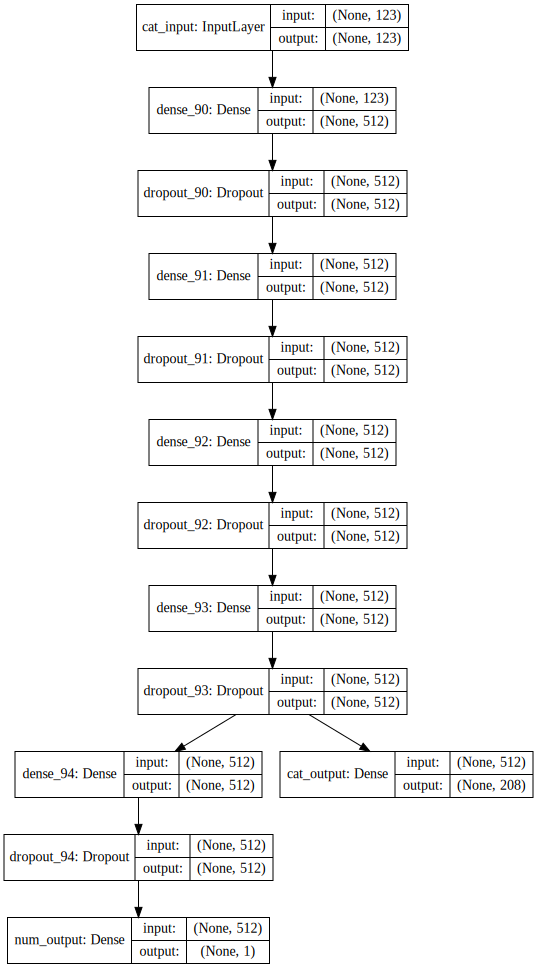

In [526]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

%matplotlib inline

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [534]:
# set result array to each cases
def setResult(arr, predict, case):

    result_arr = arr
    if case == 'Case1':
        result_arr[:, 2] = predict[:, 0]
        result_arr[:, 5] = predict[:, 1]

        result_arr[:, 3] = result_arr[:, 2].sum() + result_arr[:, 4:6].sum()

    print(result_arr)

In [ ]:
## 사용예

# x_test = pd.read_csv('./samsung_dataset/test_kor.csv',encoding='cp949')
# print(x_test.loc[:0].values)

# arr = x_test.loc[:0].values
# # arr[:, 2] = predict[0]
# print(arr[:, 2])

# predict = np.array([[1.0412397 , 0.6131577 ]])
# current_case = 'Case1'

# a = MyModule()
# a.setResult(arr, predict, current_case)

In [ ]:
setResult()